In [30]:
from adjustText import adjust_text

In [10]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
import harmonypy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import copy

# Helper Functions

In [28]:
def gen_mpl_labels(adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None, offset=(0.05, 0.05)):
    if adjust_kwargs is None:
        adjust_kwargs = {
            "arrowprops": {"arrowstyle": "->", "color": 'r'}, 
            "expand_points": (1.2, 1.2), 
            "force_points": 0.5
        }
    if text_kwargs is None:
        text_kwargs = {}

    highest_density_points = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        points = adata[g_idx].obsm["X_umap"]
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[50, 50])
        max_bin = np.unravel_index(np.argmax(hist), hist.shape)
        highest_density_point = [
            (xedges[max_bin[0]] + xedges[max_bin[0]+1])/2 + offset[0], 
            (yedges[max_bin[1]] + yedges[max_bin[1]+1])/2 + offset[1]
        ]
        highest_density_points[g] = highest_density_point

    if ax is None:
        ax = plt.gca()

    texts = [
        ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in highest_density_points.items()
    ]

    adjust_text(texts, **adjust_kwargs)

## Color annotation for celltype labeling order from HISE

In [24]:
colors=pd.read_csv('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/cache/9034d426-6447-4c3e-b9ff-4ca3e814a15f/AIFI_pbmc_type_order_and_colorset_2024-05-08.csv')
color_dict=dict(zip(colors.AIFI_L3, colors.AIFI_L3_color))

In [11]:
# Read the CSV file
label_data = pd.read_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/cache/9034d426-6447-4c3e-b9ff-4ca3e814a15f/AIFI_pbmc_type_order_and_colorset_2024-05-08.csv")

# Extract the desired labels and colors
desired_labels = label_data['AIFI_L3'].tolist()
desired_color = label_data['AIFI_L3_color'].tolist()

In [14]:
#desired_color

In [15]:
#table( label_data$AIFI_L3_color, label_data$AIFI_L3)
label_data.head()

AIFI_L1 AIFI_L1_name  AIFI_L1_id AIFI_L1_color            AIFI_L2  \
0  T cell            t           1       #5480A3   Naive CD4 T cell   
1  T cell            t           1       #5480A3   Naive CD4 T cell   
2  T cell            t           1       #5480A3   Naive CD4 T cell   
3  T cell            t           1       #5480A3  Memory CD4 T cell   
4  T cell            t           1       #5480A3  Memory CD4 T cell   

   AIFI_L2_name  AIFI_L2_id AIFI_L2_color                    AIFI_L3  \
0   t_cd4-naive           1       #597FC6     SOX4+ naive CD4 T cell   
1   t_cd4-naive           1       #597FC6      Core naive CD4 T cell   
2   t_cd4-naive           1       #597FC6      ISG+ naive CD4 T cell   
3  t_cd4-memory           2       #233C5B              CM CD4 T cell   
4  t_cd4-memory           2       #233C5B  GZMB- CD27+ EM CD4 T cell   

                              AIFI_L3_name  AIFI_L3_id AIFI_L3_color  
0                     t_cd4-naive_sox4.pos           1       #2B5777  
1                         t_cd4-naive_core           2       #597FC6  
2                      t_cd4-naive_isg.pos           3       #072E77  
3                     t_cd4-memory_central           4       #6793A4  
4  t_cd4-memory_effector-cd27.pos-gzmb.neg           5       #406B9C

# Anndata creation

In [5]:
adata = sc.read_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/FluYr1D0_certpro.h5ad')

In [6]:
adata.X[10:50,10:50].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [7]:
adata

AnnData object with n_obs × n_vars = 1539411 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'

In [8]:
adata.layers["counts"] = adata.X.copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 1539411 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'
    layers: 'counts'

In [10]:
# adata.write_h5ad('/home/jupyter/Myeloid_cells/files/FluYr1D0_with_counts_layer.h5ad')

In [11]:
adata.obs['cohort.cohortGuid'].unique()

['BR1', 'BR2']
Categories (2, object): ['BR1', 'BR2']

In [13]:
# Define the cell types you want to subset
selected_cell_types = ['IL1B+ CD14 monocyte', 'Core CD14 monocyte', 'Intermediate monocyte', 'Core CD16 monocyte', 'ISG+ CD16 monocyte', 'C1Q+ CD16 monocyte', 'ISG+ CD14 monocyte']
#selected_cell_types = ['IL1B+ CD14 monocyte']

subset_adata = adata[adata.obs['AIFI_L3'].isin(selected_cell_types), :]
subset_adata.obs['AIFI_L3'].value_counts()

AIFI_L3
Core CD14 monocyte       208536
ISG+ CD14 monocyte        38007
Core CD16 monocyte        31406
Intermediate monocyte     12290
ISG+ CD16 monocyte         4704
C1Q+ CD16 monocyte         3618
IL1B+ CD14 monocyte        2835
Name: count, dtype: int64

In [14]:
subset_adata

View of AnnData object with n_obs × n_vars = 301396 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'
    layers: 'counts'

In [15]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Monocyte_ONLY_FluYr1D0_certpro_raw_05172024.h5ad')

In [16]:
subset_adata.raw= subset_adata

In [17]:
subset_adata.obs

barcodes  \
barcodes                                                             
cf78ed5c48b611ea8957bafe6d70929e  cf78ed5c48b611ea8957bafe6d70929e   
cf7f65ce48b611ea8957bafe6d70929e  cf7f65ce48b611ea8957bafe6d70929e   
cf804c0a48b611ea8957bafe6d70929e  cf804c0a48b611ea8957bafe6d70929e   
cf8060be48b611ea8957bafe6d70929e  cf8060be48b611ea8957bafe6d70929e   
cf85272a48b611ea8957bafe6d70929e  cf85272a48b611ea8957bafe6d70929e   
...                                                            ...   
92069756286311ecabc39e0459bddc54  92069756286311ecabc39e0459bddc54   
92071fe6286311ecabc39e0459bddc54  92071fe6286311ecabc39e0459bddc54   
9208e02e286311ecabc39e0459bddc54  9208e02e286311ecabc39e0459bddc54   
9210332e286311ecabc39e0459bddc54  9210332e286311ecabc39e0459bddc54   
92125fdc286311ecabc39e0459bddc54  92125fdc286311ecabc39e0459bddc54   

                                 original_barcodes  \
barcodes                                             
cf78ed5c48b611ea8957bafe6d70929e  AGAAGTACAGAGTCTT   
cf7f65ce48b611ea8957bafe6d70929e  ATCACTTGTTCAACGT   
cf804c0a48b611ea8957bafe6d70929e  ATCGGATAGATACGAT   
cf8060be48b611ea8957bafe6d70929e  ATCGGATTCCGTTGGG   
cf85272a48b611ea8957bafe6d70929e  CACAACACAAATCAGA   
...                                            ...   
92069756286311ecabc39e0459bddc54  GTCGAATGTCTCTCAC   
92071fe6286311ecabc39e0459bddc54  GTGAGTTAGCACTTTG   
9208e02e286311ecabc39e0459bddc54  TAACGACGTGTTCGTA   
9210332e286311ecabc39e0459bddc54  TGGATGTCAAGCGAAC   
92125fdc286311ecabc39e0459bddc54  TTCCTAACATCCAATG   

                                                        cell_name batch_id  \
barcodes                                                                     
cf78ed5c48b611ea8957bafe6d70929e        jockeyish_goofy_schnauzer     B001   
cf7f65ce48b611ea8957bafe6d70929e         releasable_cussed_cuscus     B001   
cf804c0a48b611ea8957bafe6d70929e  ergophobic_cumulative_gallinule     B001   
cf8060be48b611ea8957bafe6d70929e         conchin_sandstone_bobcat     B001   
cf85272a48b611ea8957bafe6d70929e    petalless_depressed_barracuda     B001   
...                                                           ...      ...   
92069756286311ecabc39e0459bddc54      convulsant_atrocious_cattle     B085   
92071fe6286311ecabc39e0459bddc54    stationary_splurgy_alpinegoat     B085   
9208e02e286311ecabc39e0459bddc54          climatic_costly_penguin     B085   
9210332e286311ecabc39e0459bddc54           pernickety_cotton_degu     B085   
92125fdc286311ecabc39e0459bddc54            pitiful_copper_nandoo     B085   

                                  pool_id    chip_id      well_id  n_genes  \
barcodes                                                                     
cf78ed5c48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1148   
cf7f65ce48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1754   
cf804c0a48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1399   
cf8060be48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     2258   
cf85272a48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1762   
...                                   ...        ...          ...      ...   
92069756286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2678   
92071fe6286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     3181   
9208e02e286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2805   
9210332e286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2252   
92125fdc286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     3665   

                                  n_reads  n_umis  ...  subject.bmi  \
barcodes                                           ...                
cf78ed5c48b611ea8957bafe6d70929e     9002    2687  ...         23.0   
cf7f65ce48b611ea8957bafe6d70929e    15865    4930  ...         23.0   
cf804c0a48b611ea8957bafe6d70929e    11566    3499  ...         23.0   
cf8060be48b611ea8957bafe6d70929e    23436    7020  ...     

In [18]:
%%time
sc.pp.normalize_total(subset_adata, target_sum=1e4)
sc.pp.log1p(subset_adata)

CPU times: user 5.96 s, sys: 5.04 s, total: 11 s
Wall time: 11.1 s


In [19]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Monocyte_ONLY_FluYr1D0_certpro_normalized_unscaled_05172024.h5ad')

In [20]:
%%time

sc.pp.highly_variable_genes(subset_adata)
subset_adata = subset_adata[:, subset_adata.var_names[subset_adata.var['highly_variable']]]

CPU times: user 7.85 s, sys: 2.42 s, total: 10.3 s
Wall time: 23.6 s


In [21]:
sc.pp.scale(subset_adata)

In [22]:
sc.tl.pca(subset_adata, svd_solver='arpack')

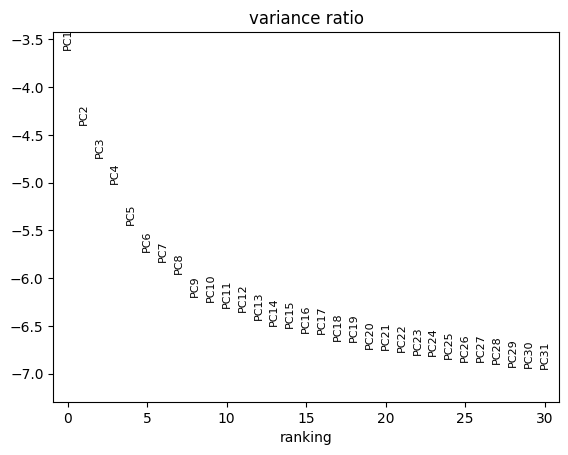

In [23]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [24]:
%%time

sce.pp.harmony_integrate(subset_adata, 'cohort.cohortGuid',max_iter_harmony = 30)

2024-05-17 18:54:01,502 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-05-17 18:56:33,497 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-05-17 18:56:34,943 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2024-05-17 18:59:24,044 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2024-05-17 19:02:14,140 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2024-05-17 19:05:09,589 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2024-05-17 19:07:40,714 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2024-05-17 19:10:27,737 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2024-05-17 19:11:49,059 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2024-05-17 19:13:10,405 - harmonypy - INFO - Iteration 8 of 30
Iteration 8 of 30
2024-05-17 19:14:22,638 - harmonypy - INFO - Converged after 8 iterations
Conver

CPU times: user 6h 23min 12s, sys: 7h 52min 36s, total: 14h 15min 48s
Wall time: 20min 21s


In [25]:
%%time

sc.pp.neighbors(subset_adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(subset_adata)

CPU times: user 59min 24s, sys: 35min 58s, total: 1h 35min 22s
Wall time: 10min 28s


In [26]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Monocyte_ONLY_FluYr1D0_certpro_post_harmony_05172024.h5ad')

In [27]:
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

In [ ]:
%%time


tasks = [(0.5, "leiden_resolution_0.5"),(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
subset_adata = run_leiden_parallel(subset_adata, tasks)

In [ ]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Monocyte_ONLY_FluYr1D0_certpro_processed_05172024.h5ad')

In [107]:
#subset_adata.write_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [108]:
subset_adata

AnnData object with n_obs × n_vars = 2835 × 2710
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
  

In [109]:
#adata = sc.read_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [110]:
obs = subset_adata.obs

In [111]:
obs

barcodes  \
barcodes                                                             
70ab258848b611eaa65d9e7d578d66f2  70ab258848b611eaa65d9e7d578d66f2   
70acf29648b611eaa65d9e7d578d66f2  70acf29648b611eaa65d9e7d578d66f2   
70d2b34648b611eaa65d9e7d578d66f2  70d2b34648b611eaa65d9e7d578d66f2   
a711a6d8489811ea92388a6a0c683ffb  a711a6d8489811ea92388a6a0c683ffb   
a78438c4489811ea92388a6a0c683ffb  a78438c4489811ea92388a6a0c683ffb   
...                                                            ...   
ce432b48286411eca744faae388e9f17  ce432b48286411eca744faae388e9f17   
ce49cb56286411eca744faae388e9f17  ce49cb56286411eca744faae388e9f17   
fbe4aa18286411ecb1698ec288c6fba6  fbe4aa18286411ecb1698ec288c6fba6   
03c5255a286511ec8289ca5980196c9c  03c5255a286511ec8289ca5980196c9c   
91f8844a286311ecabc39e0459bddc54  91f8844a286311ecabc39e0459bddc54   

                                 original_barcodes  \
barcodes                                             
70ab258848b611eaa65d9e7d578d66f2  ATCACTTAGATACAGT   
70acf29648b611eaa65d9e7d578d66f2  ATGCCTCGTTTGAACC   
70d2b34648b611eaa65d9e7d578d66f2  TCAGTTTAGCGCCTCA   
a711a6d8489811ea92388a6a0c683ffb  AGACCATAGCGTCAAG   
a78438c4489811ea92388a6a0c683ffb  TTCCACGTCTTTCCGG   
...                                            ...   
ce432b48286411eca744faae388e9f17  TAGGTACCATGTAACC   
ce49cb56286411eca744faae388e9f17  TGTAGACAGTCAACAA   
fbe4aa18286411ecb1698ec288c6fba6  ATTCACTCAGGTATGG   
03c5255a286511ec8289ca5980196c9c  GGGCTCAAGGGCAAGG   
91f8844a286311ecabc39e0459bddc54  CCACACTCAAGAGATT   

                                                       cell_name batch_id  \
barcodes                                                                    
70ab258848b611eaa65d9e7d578d66f2          pine_enervated_caracal     B001   
70acf29648b611eaa65d9e7d578d66f2                 bland_sandy_owl     B001   
70d2b34648b611eaa65d9e7d578d66f2             mellow_intact_gecko     B001   
a711a6d8489811ea92388a6a0c683ffb    villainous_preoceanic_jackal     B001   
a78438c4489811ea92388a6a0c683ffb        abdicable_centerable_gnu     B001   
...                                                          ...      ...   
ce432b48286411eca744faae388e9f17                sly_fleshy_kitty     B085   
ce49cb56286411eca744faae388e9f17         cavitied_amebic_wildcat     B085   
fbe4aa18286411ecb1698ec288c6fba6    topnotch_antelopine_chipmunk     B085   
03c5255a286511ec8289ca5980196c9c  emigrative_untalented_scorpion     B085   
91f8844a286311ecabc39e0459bddc54            elated_clumpy_bonobo     B085   

                                  pool_id    chip_id      well_id  n_genes  \
barcodes                                                                     
70ab258848b611eaa65d9e7d578d66f2  B001-P1  B001-P1C1  B001-P1C1W2     2354   
70acf29648b611eaa65d9e7d578d66f2  B001-P1  B001-P1C1  B001-P1C1W2     4302   
70d2b34648b611eaa65d9e7d578d66f2  B001-P1  B001-P1C1  B001-P1C1W2     2176   
a711a6d8489811ea92388a6a0c683ffb  B001-P1  B001-P1C1  B001-P1C1W3     1287   
a78438c4489811ea92388a6a0c683ffb  B001-P1  B001-P1C1  B001-P1C1W3     1051   
...                                   ...        ...          ...      ...   
ce432b48286411eca744faae388e9f17  B085-P2  B085-P2C3  B085-P2C3W3     2974   
ce49cb56286411eca744faae388e9f17  B085-P2  B085-P2C3  B085-P2C3W3     3483   
fbe4aa18286411ecb1698ec288c6fba6  B085-P2  B085-P2C3  B085-P2C3W4     1595   
03c5255a286511ec8289ca5980196c9c  B085-P2  B085-P2C3  B085-P2C3W6     2602   
91f8844a286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     3877   

                                  n_reads  n_umis  ...  \
barcodes                                           ...   
70ab258848b611eaa65d9e7d578d66f2    27740    8105  ...   
70acf29648b611eaa65d9e7d578d66f2    73872   21505  ...   
70d2b34648b611eaa65d9e7d578d66f2    20037    6038  ...   
a711a6d8489811ea92388a6a0c683ffb     9010    2906  ...   
a78438c4489811ea92388a6a0c683ffb     6492    2278  ...   
...                  

In [112]:
obs.to_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Il1B_Cd14_mono_obsdata_certpro.csv", index= False)

# Clustering analysis

In [16]:
adata = sc.read ('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Monocyte_ONLY_FluYr1D0_certpro_processed_05172024.h5ad')
adata

AnnData object with n_obs × n_vars = 301396 × 1470
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'


In [17]:
obs = adata.obs

In [18]:
obs

barcodes  \
barcodes                                                             
cf78ed5c48b611ea8957bafe6d70929e  cf78ed5c48b611ea8957bafe6d70929e   
cf7f65ce48b611ea8957bafe6d70929e  cf7f65ce48b611ea8957bafe6d70929e   
cf804c0a48b611ea8957bafe6d70929e  cf804c0a48b611ea8957bafe6d70929e   
cf8060be48b611ea8957bafe6d70929e  cf8060be48b611ea8957bafe6d70929e   
cf85272a48b611ea8957bafe6d70929e  cf85272a48b611ea8957bafe6d70929e   
...                                                            ...   
92069756286311ecabc39e0459bddc54  92069756286311ecabc39e0459bddc54   
92071fe6286311ecabc39e0459bddc54  92071fe6286311ecabc39e0459bddc54   
9208e02e286311ecabc39e0459bddc54  9208e02e286311ecabc39e0459bddc54   
9210332e286311ecabc39e0459bddc54  9210332e286311ecabc39e0459bddc54   
92125fdc286311ecabc39e0459bddc54  92125fdc286311ecabc39e0459bddc54   

                                 original_barcodes  \
barcodes                                             
cf78ed5c48b611ea8957bafe6d70929e  AGAAGTACAGAGTCTT   
cf7f65ce48b611ea8957bafe6d70929e  ATCACTTGTTCAACGT   
cf804c0a48b611ea8957bafe6d70929e  ATCGGATAGATACGAT   
cf8060be48b611ea8957bafe6d70929e  ATCGGATTCCGTTGGG   
cf85272a48b611ea8957bafe6d70929e  CACAACACAAATCAGA   
...                                            ...   
92069756286311ecabc39e0459bddc54  GTCGAATGTCTCTCAC   
92071fe6286311ecabc39e0459bddc54  GTGAGTTAGCACTTTG   
9208e02e286311ecabc39e0459bddc54  TAACGACGTGTTCGTA   
9210332e286311ecabc39e0459bddc54  TGGATGTCAAGCGAAC   
92125fdc286311ecabc39e0459bddc54  TTCCTAACATCCAATG   

                                                        cell_name batch_id  \
barcodes                                                                     
cf78ed5c48b611ea8957bafe6d70929e        jockeyish_goofy_schnauzer     B001   
cf7f65ce48b611ea8957bafe6d70929e         releasable_cussed_cuscus     B001   
cf804c0a48b611ea8957bafe6d70929e  ergophobic_cumulative_gallinule     B001   
cf8060be48b611ea8957bafe6d70929e         conchin_sandstone_bobcat     B001   
cf85272a48b611ea8957bafe6d70929e    petalless_depressed_barracuda     B001   
...                                                           ...      ...   
92069756286311ecabc39e0459bddc54      convulsant_atrocious_cattle     B085   
92071fe6286311ecabc39e0459bddc54    stationary_splurgy_alpinegoat     B085   
9208e02e286311ecabc39e0459bddc54          climatic_costly_penguin     B085   
9210332e286311ecabc39e0459bddc54           pernickety_cotton_degu     B085   
92125fdc286311ecabc39e0459bddc54            pitiful_copper_nandoo     B085   

                                  pool_id    chip_id      well_id  n_genes  \
barcodes                                                                     
cf78ed5c48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1148   
cf7f65ce48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1754   
cf804c0a48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1399   
cf8060be48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     2258   
cf85272a48b611ea8957bafe6d70929e  B001-P1  B001-P1C1  B001-P1C1W1     1762   
...                                   ...        ...          ...      ...   
92069756286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2678   
92071fe6286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     3181   
9208e02e286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2805   
9210332e286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     2252   
92125fdc286311ecabc39e0459bddc54  B085-P2  B085-P2C3  B085-P2C3W7     3665   

                                  n_reads  n_umis  ...  \
barcodes                                           ...   
cf78ed5c48b611ea8957bafe6d70929e     9002    2687  ...   
cf7f65ce48b611ea8957bafe6d70929e    15865    4930  ...   
cf804c0a48b611ea8957bafe6d70929e    11566    3499  ...   
cf8060be48b611ea8957bafe6d70929e    23436    7020  ...   
cf85272a48b611ea8957bafe6d70929e    19457    5787  ...   
...     

In [19]:
#obs.to_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Frequency_Plot/Il1B_Cd14_mono_obsdata_v2.csv", index= False)

In [20]:
adata.X

array([[-0.3111329 , -0.7091268 , -0.2218949 , ..., -0.21066022,
        -0.41027197, -0.22333348],
       [-0.3111329 ,  1.4861935 , -0.2218949 , ..., -0.9325147 ,
         2.6008954 , -0.22333348],
       [-0.3111329 ,  3.7411234 , -0.2218949 , ..., -0.03369841,
        -0.41027197, -0.22333348],
       ...,
       [-0.3111329 ,  2.6459851 , -0.2218949 , ..., -0.40375292,
        -0.41027197, -0.22333348],
       [-0.3111329 , -0.7091268 , -0.2218949 , ...,  0.35786858,
        -0.41027197, -0.22333348],
       [ 0.9248491 , -0.7091268 , -0.2218949 , ..., -0.33233097,
        -0.41027197, -0.22333348]], dtype=float32)

In [21]:
adata

AnnData object with n_obs × n_vars = 301396 × 1470
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'


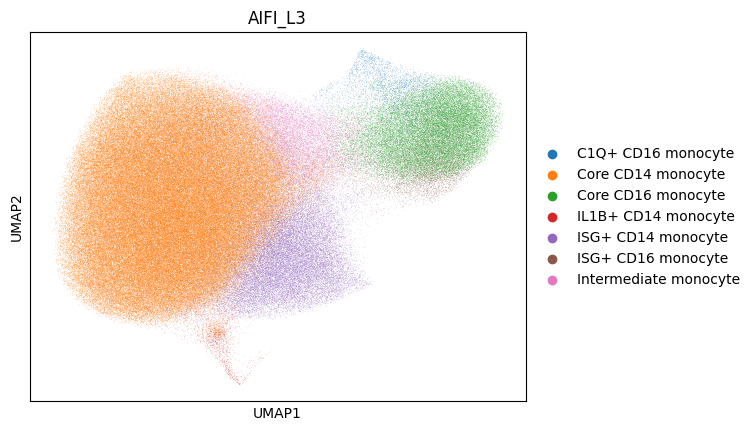

In [22]:
sc.pl.umap(adata, color=['AIFI_L3'])

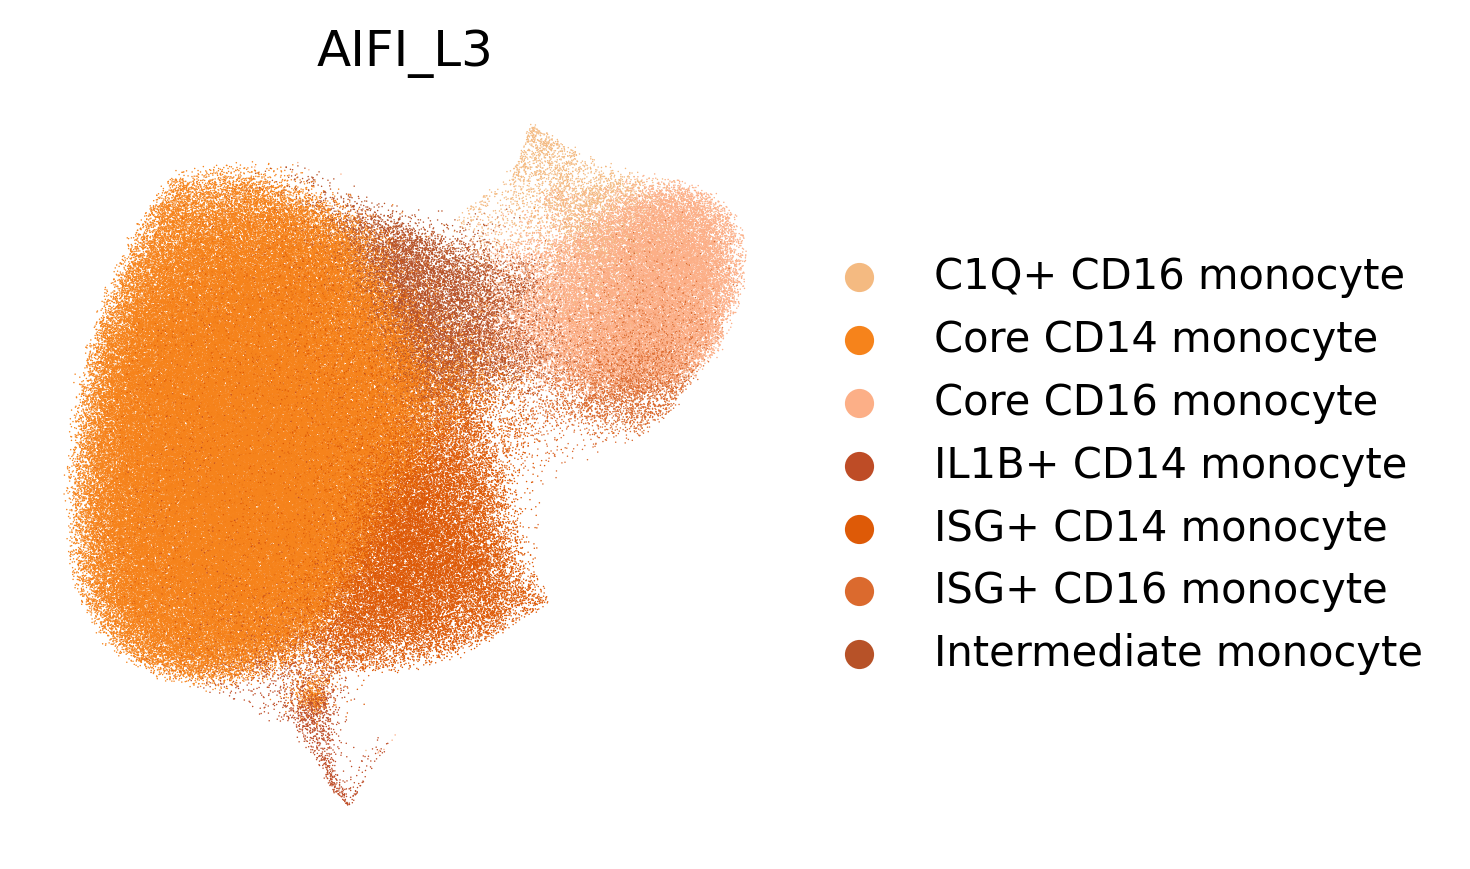

In [26]:
with plt.rc_context({"figure.figsize": (5, 3), "figure.dpi": 300, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L3'], size=0.5,show=False,ncols=1 ,palette=color_dict,frameon=False)
    fig = ax.get_figure()
    fig.tight_layout()

In [33]:
with plt.rc_context({"figure.figsize": (4, 3), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L3'], size=0.5,show=False,legend_loc=None,ncols=1,palette=color_dict,frameon=False)
    gen_mpl_labels(
        adata,
        "AIFI_L3",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=5),)
    fig = ax.get_figure()
    fig.tight_layout()

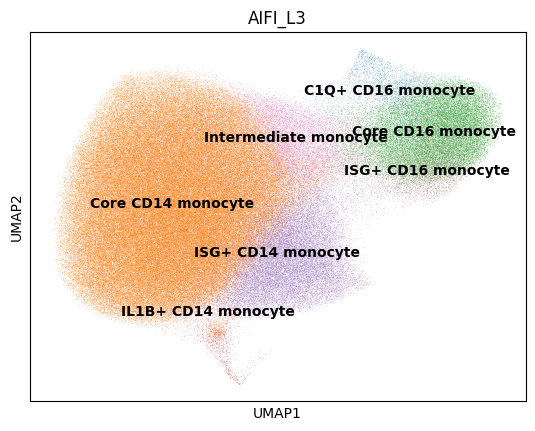

In [52]:
sc.pl.umap(adata, color=['AIFI_L3'], legend_loc= 'on data')

In [42]:
# sc.pl.umap(adata, color=['cohort.cohortGuid'])

In [43]:
# sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Male")

In [44]:
# sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Female")

In [45]:
# sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR1")

In [46]:
# sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR2")

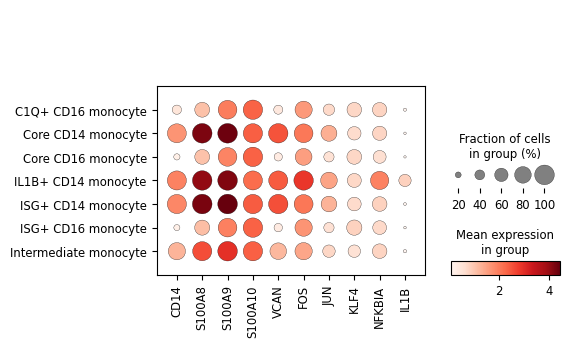

In [50]:
sc.pl.dotplot(adata, ['CD14', 'S100A8', 'S100A9', 'S100A10', 'VCAN', 'FOS', 'JUN', 'KLF4', 'NFKBIA', 'IL1B'], "AIFI_L3",
              #save=  proj_name+'_rna_TNF_dotpolt.png',
              dendrogram=False, log= True)

In [145]:
adata.obs['subject.biologicalSex'].value_counts()

subject.biologicalSex
Male      1704
Female    1131
Name: count, dtype: int64

In [146]:
adata.obs['cohort.cohortGuid'].value_counts()

cohort.cohortGuid
BR2    1732
BR1    1103
Name: count, dtype: int64

In [147]:
adata.obs['new_column'].value_counts()

new_column
Male_BR2      1077
Female_BR2     655
Male_BR1       627
Female_BR1     476
Name: count, dtype: int64

In [148]:
# Group the data by cluster labels and aggregate the donors
donors_per_cluster = adata.obs.groupby('new_column')['subject.subjectGuid'].nunique()

# Print the list of donors per cluster
print(donors_per_cluster)

new_column
Female_BR1    26
Female_BR2    25
Male_BR1      21
Male_BR2      20
Name: subject.subjectGuid, dtype: int64
